In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [16]:
plt.style.use('fivethirtyeight')

In [2]:
%%html
<style>
.cm-comment {
    color: white !important;
}
</style>

In [3]:
time_series= pd.read_csv('timeseries_rev.csv',parse_dates=True)
time_series.info()
time_series['date']= pd.to_datetime(time_series['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     104 non-null    int64  
 1   week           104 non-null    int64  
 2   year           104 non-null    int64  
 3   date           104 non-null    object 
 4   total_revenue  104 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.2+ KB


In [4]:
time_series= time_series.set_index('date')

In [5]:
time_series

,Unnamed: 0,week,year,total_revenue
date,,,,
2009-12-01,96,49,2009,232177.51
2009-12-07,99,50,2009,207908.73
2009-12-14,101,51,2009,207685.87
2009-12-21,103,52,2009,35731.90
2010-01-04,0,1,2010,167636.95
...,...,...,...,...
2011-11-07,89,45,2011,263717.33
2011-11-14,91,46,2011,276216.98
2011-11-21,93,47,2011,248234.58


In [7]:
monthly_series= time_series.total_revenue.resample('M').sum()

In [8]:
monthly_series=pd.DataFrame(monthly_series)

In [9]:
monthly_series.columns

Index(['total_revenue'], dtype='object')

In [10]:
monthly_series.isnull().sum()

total_revenue    0
dtype: int64

<Axes: xlabel='date'>

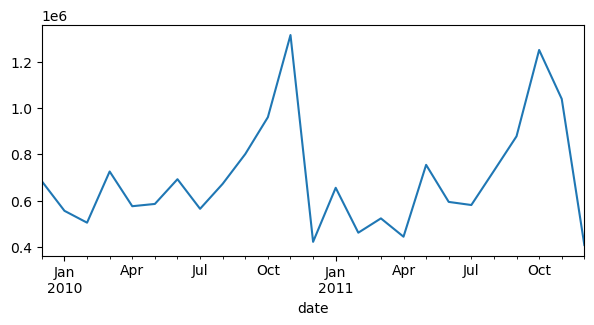

In [11]:
monthly_series['total_revenue'].plot(figsize=(7,3))

In [13]:
components=sm.tsa.seasonal_decompose(monthly_series)

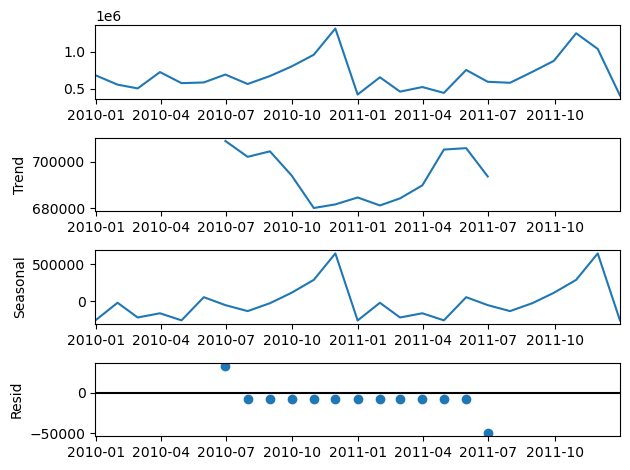

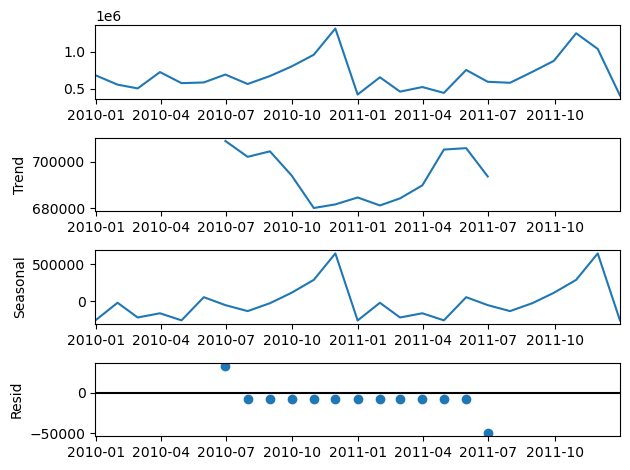

In [15]:
trend=components.trend
#components.trend.plot(figsize=(7,2))
components.plot()

<Axes: xlabel='date'>

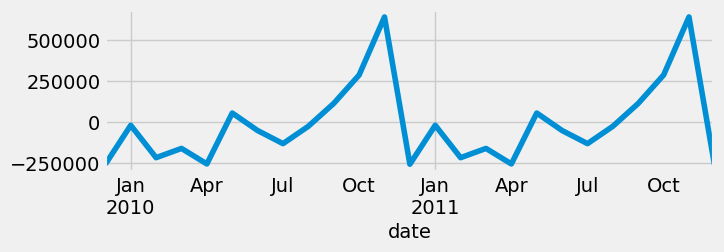

In [17]:
seasonal=components.seasonal
components.seasonal.plot(figsize=(7,2))

<Axes: xlabel='date'>

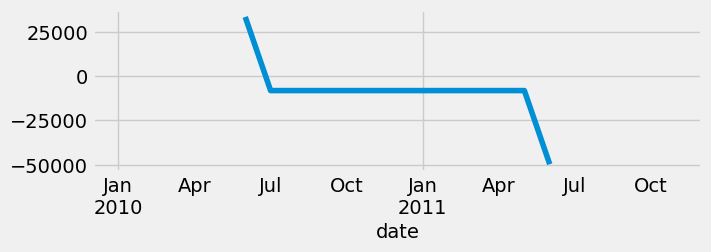

In [45]:
resid=components.resid
components.resid.plot(figsize=(7,2))

<Axes: xlabel='date'>

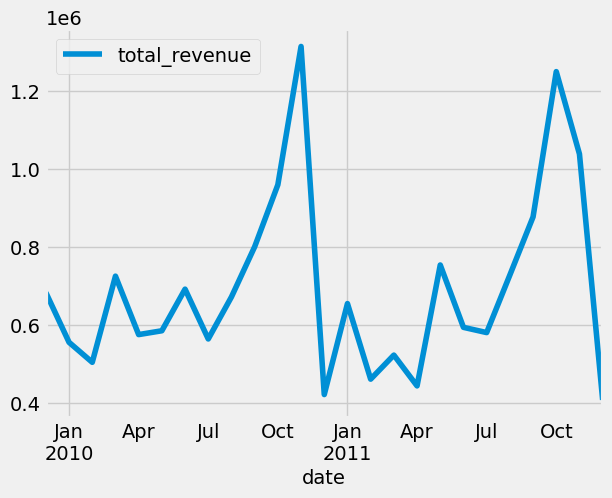

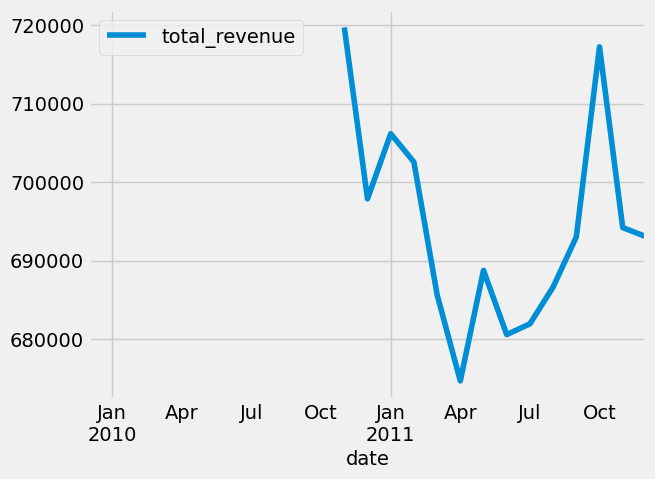

In [18]:
monthly_series.plot()
monthly_series.rolling(window=12).mean().plot()

In [19]:
ad_fuller_test= sm.tsa.stattools.adfuller(monthly_series,autolag='AIC')
ad_fuller_test

(-3.653870927875697,
 0.004810825532850623,
 9,
 15,
 {'1%': -3.9644434814814815,
  '5%': -3.0849081481481484,
  '10%': -2.6818144444444445},
 418.76495184065936)

In [63]:
monthly_series.shape

(25, 1)

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


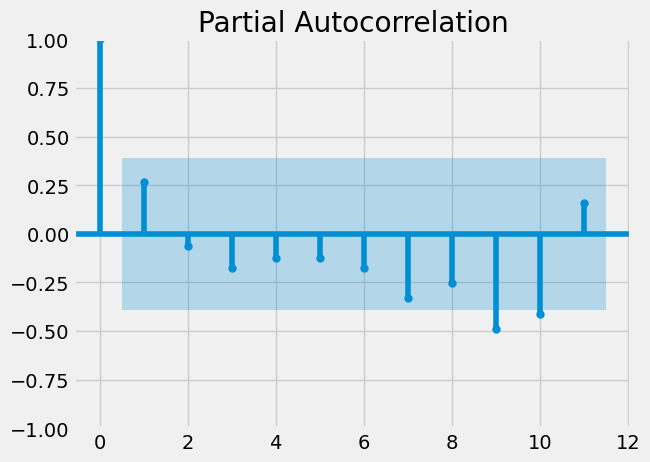

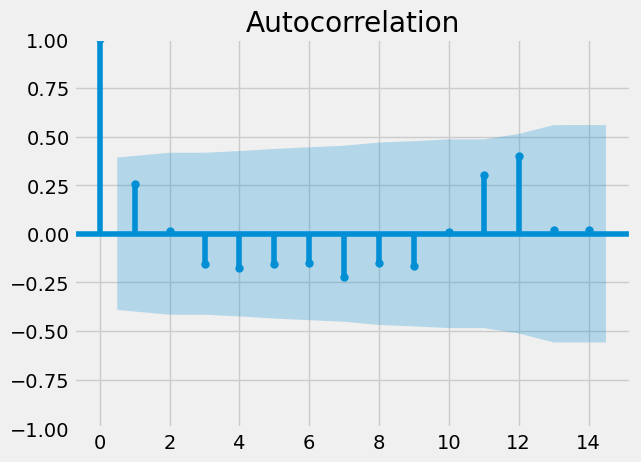

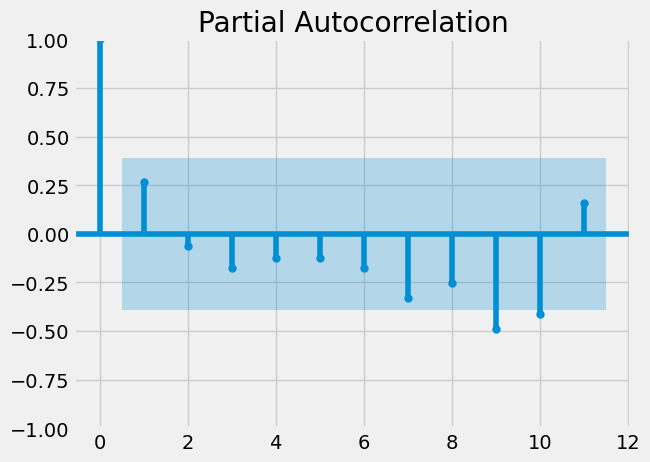

In [20]:

from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf

plot_acf(monthly_series['total_revenue'])
plot_pacf(monthly_series['total_revenue'],lags=np.arange(12))

In [21]:
model_ma= sm.tsa.statespace.SARIMAX(monthly_series,order= (0,0,1))
results_ma= model_ma.fit()

print(f"Moving Average Model: {results_ma.aic}")


model_AR= sm.tsa.statespace.SARIMAX(monthly_series,order= (1,0,0))
results_AR= model_AR.fit()

print(f"Auto Regressive Model: {results_AR.aic}")


model_ARma= sm.tsa.statespace.SARIMAX(monthly_series,order= (1,0,1))
results_ARma= model_ARma.fit()

print(f"ARMA Model: {results_ARma.aic}")


model_ARima= sm.tsa.statespace.SARIMAX(monthly_series,order= (1,1,1))
results_ARima= model_ARima.fit()

print(f"ARIMA Model: {results_ARima.aic}")



C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Moving Average Model: 735.7906414433097
Auto Regressive Model: 703.4620739015512
ARMA Model: 702.1603952408891
ARIMA Model: 672.026177170789


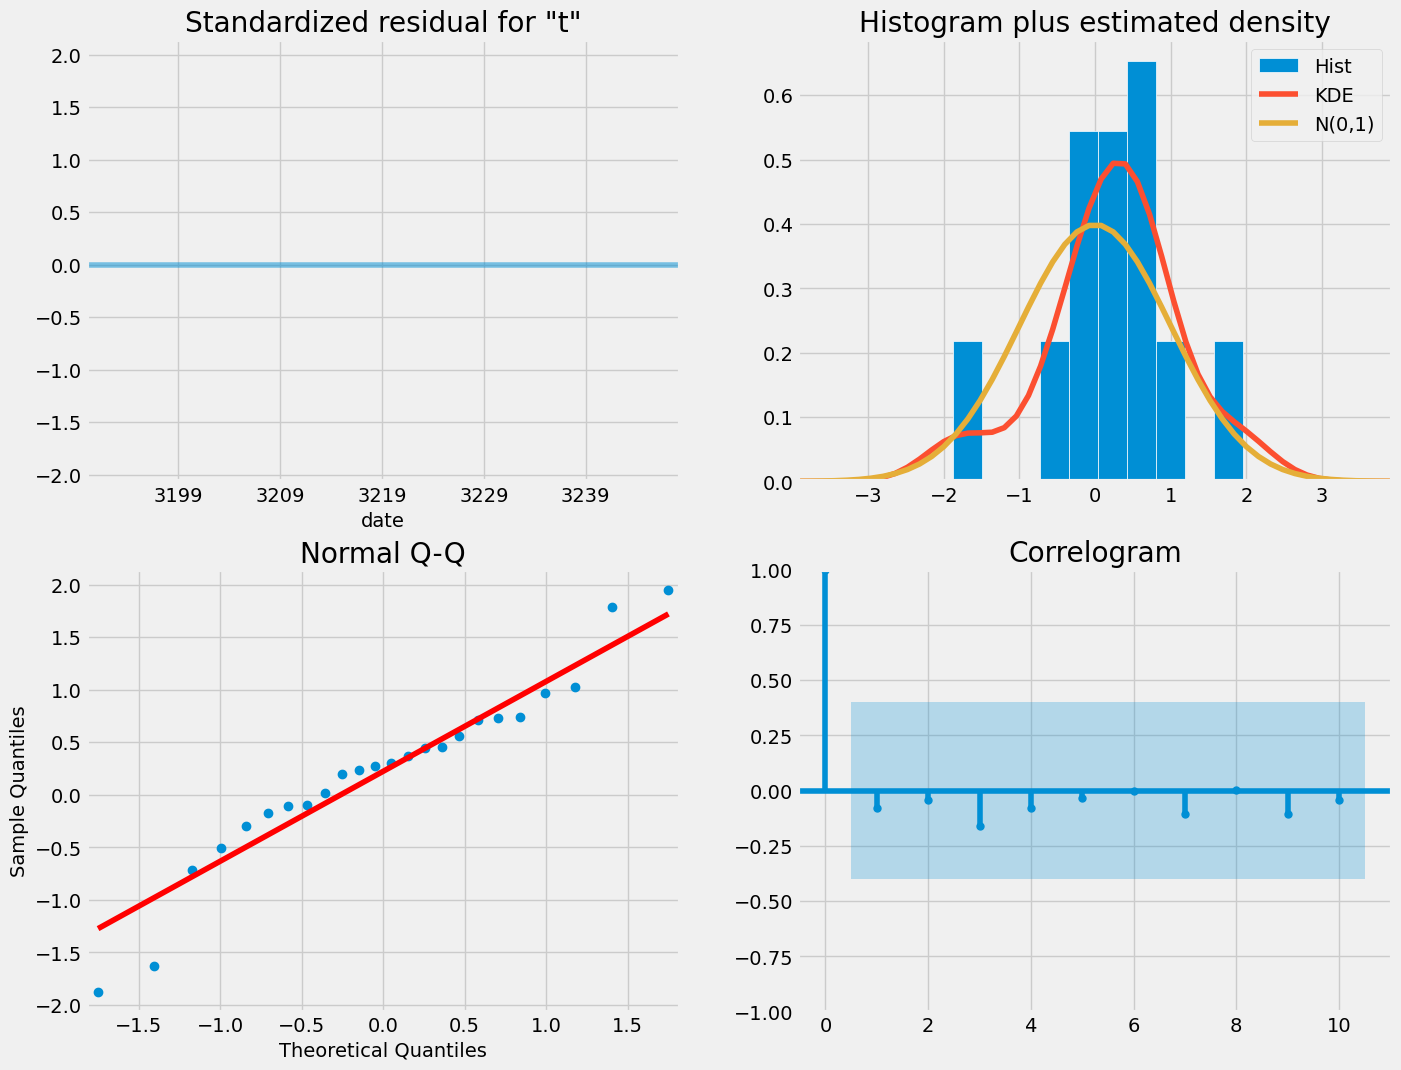

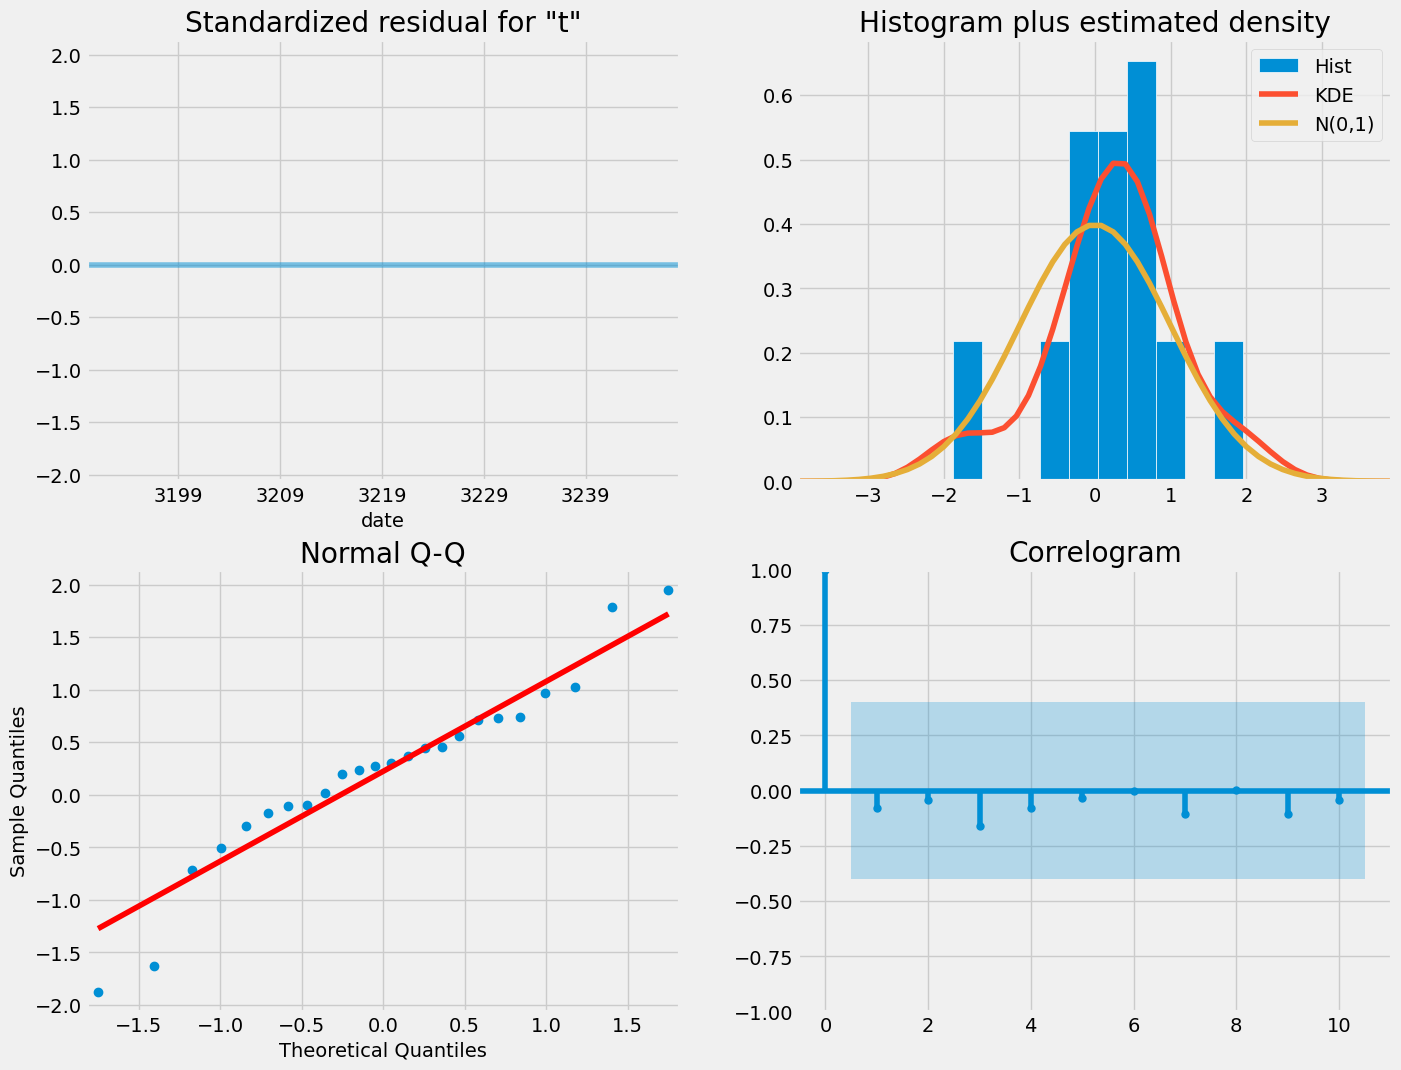

In [22]:
results_ARima.plot_diagnostics(figsize=(15, 12))

In [23]:
import itertools

In [24]:
p=d=q=P=D=Q=range(0,3)
S=12
combinations=list(itertools.product(p,d,q,P,D,Q))

arima_order=[(x[0],x[1],x[2]) for x in combinations]
seasonal_order=[(x[3],x[4],x[5],S) for x in combinations]

In [25]:
result_data=pd.DataFrame(columns=['p','d','q','P','D','Q','AIC'])

In [26]:
for i in range(len(combinations)):
    try:
        
        model=sm.tsa.statespace.SARIMAX(monthly_series,order=arima_order[i],seasonal_order=seasonal_order[i])
        result=model.fit()
        result_data.loc[i,'p']=arima_order[i][0]
        result_data.loc[i,'d']=arima_order[i][1]
        result_data.loc[i,'q']=arima_order[i][2]
        result_data.loc[i,'P']=seasonal_order[i][0]
        result_data.loc[i,'D']=seasonal_order[i][1]
        result_data.loc[i,'Q']=seasonal_order[i][2]
        result_data.loc[i,'AIC']=result.aic

    except:
        continue

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacond

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting 

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:9

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting 

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide


C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacond

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacon

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaco

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting p

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacond

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stati

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacon

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacond

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting 

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate startin

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting 

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacond

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacon

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divi

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacond

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacond

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to es

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacon

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to 

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting p

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacond

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anacond

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except f

C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\bharat.sakarwal\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to es

In [96]:
result_data

,p,d,q,P,D,Q,AIC
0,0,0,0,0,0,0,748.198753
1,0,0,0,0,0,1,765.394858
2,0,0,0,0,0,2,733.323416
3,0,0,0,0,1,0,354.479831
4,0,0,0,0,1,1,352.462424
...,...,...,...,...,...,...,...
724,2,2,2,2,1,1,314.755944
725,2,2,2,2,1,2,315.624908
726,2,2,2,2,2,0,14.0
727,2,2,2,2,2,1,16.0


In [37]:
result_data.sort_values('AIC',ascending=True).head(50)
                                                  

,p,d,q,P,D,Q,AIC
87,0,1,0,0,2,0,2.0
168,0,2,0,0,2,0,2.0
88,0,1,0,0,2,1,4.0
195,0,2,1,0,2,0,4.0
411,1,2,0,0,2,0,4.0
114,0,1,1,0,2,0,4.0
330,1,1,0,0,2,0,4.0
169,0,2,0,0,2,1,4.0
123,0,1,1,1,2,0,6.0
222,0,2,2,0,2,0,6.0


In [100]:
best_result=result_data[result_data['AIC']==result_data['AIC'].min()]

In [101]:
best_result

,p,d,q,P,D,Q,AIC
87,0,1,0,0,2,0,2.0
168,0,2,0,0,2,0,2.0


In [69]:
monthly_series

,total_revenue
date,
2009-12-31,683504.010
2010-01-31,555802.672
2010-02-28,504558.956
2010-03-31,725625.131
2010-04-30,575677.512
2010-05-31,585491.210
2010-06-30,692303.570
2010-07-31,564441.680
2010-08-31,672394.450


In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [50]:
#best_model=SARIMAX(monthly_series,order=(0,1,0),seasonal_order= (0,2,1,12))---2nd attempt

#best_model=SARIMAX(monthly_series,order=(0,1,0),seasonal_order= (0,2,1,12))

#model_SARIMA=SARIMAX(train_data['Total Sales'],order=(5,2,1),seasonal_order=(0,2,1,3))

In [94]:
#results=best_model.fit()

In [60]:
fitting= results.get_prediction(start= '2009-12-31')

AttributeError: 'ARIMA' object has no attribute 'get_prediction'

In [61]:
from pmdarima import auto_arima

In [62]:
model = auto_arima(monthly_series['total_revenue'], start_p=0, start_q=0,
                           max_p=3, max_q=3, m=12, # p,q = 1, 2, 3 
                           start_P=0,start_Q=0,max_P=3,max_Q=3,seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)  # Set m to the appropriate seasonal period
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=339.219, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=332.244, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=332.405, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=331.653, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=332.252, Time=0.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=334.226, Time=0.63 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=333.901, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=332.234, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=333.566, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 2.362 seconds
331.65335509622537


In [ ]:
#Best model:  ARIMA(1,1,0)(0,1,0)[12]

In [63]:
results=model.fit(monthly_series['total_revenue'])

In [65]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   25
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -163.827
Date:                            Mon, 12 Jun 2023   AIC                            331.653
Time:                                    10:53:57   BIC                            332.623
Sample:                                12-31-2009   HQIC                           331.294
                                     - 12-31-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2987      0.186     -1.602      0.109      -0.664       0.067
sigma2      4.121e+10   1.08e-12    3.8e+22      0.000    4.12e+10    4.12e+10
===================================================================================
Ljung-Box (L1) (Q):                   2.40   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.12   Prob(JB):                         0.61
Heteroskedasticity (H):               5.69   Skew:                            -0.66
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.54e+39. Standard errors may be unstable.
"""

In [71]:
fitting=model.get_prediction

AttributeError: 'ARIMA' object has no attribute 'get_prediction'

In [72]:
fitting_mean=fitting.predicted_mean

In [86]:
fitting_mean

date
2009-12-31    0.000000e+00
2010-01-31    6.835040e+05
2010-02-28    5.558027e+05
2010-03-31    5.045590e+05
2010-04-30    7.256251e+05
2010-05-31    5.756775e+05
2010-06-30    5.854912e+05
2010-07-31    6.923036e+05
2010-08-31    5.644417e+05
2010-09-30    6.723944e+05
2010-10-31    8.010926e+05
2010-11-30    9.602256e+05
2010-12-31    1.998592e+06
2011-01-31    2.302427e+05
2011-02-28    5.783851e+05
2011-03-31    7.928950e+05
2011-04-30    2.981606e+05
2011-05-31    4.586926e+05
2011-06-30    9.145228e+05
2011-07-31    4.024652e+05
2011-08-31    7.427729e+05
2011-09-30    9.215911e+05
2011-10-31    1.116377e+06
2011-11-30    1.782823e+06
2011-12-31   -4.148557e+05
Freq: M, Name: predicted_mean, dtype: float64

In [67]:
forecast=model.predict(n_periods=len(monthly_series))

In [68]:
forecast

2012-01-31    5.631463e+05
2012-02-29    3.925942e+05
2012-03-31    4.473906e+05
2012-04-30    3.703683e+05
2012-05-31    6.800769e+05
2012-06-30    5.202170e+05
2012-07-31    5.067471e+05
2012-08-31    6.544639e+05
2012-09-30    8.035923e+05
2012-10-31    1.176446e+06
2012-11-30    9.649180e+05
2012-12-31    3.339612e+05
2013-01-31    4.890624e+05
2013-02-28    3.185104e+05
2013-03-31    3.733067e+05
2013-04-30    2.962845e+05
2013-05-31    6.059931e+05
2013-06-30    4.461332e+05
2013-07-31    4.326632e+05
2013-08-31    5.803801e+05
2013-09-30    7.295084e+05
2013-10-31    1.102362e+06
2013-11-30    8.908341e+05
2013-12-31    2.598773e+05
2014-01-31    4.149786e+05
Freq: M, dtype: float64

In [ ]:
forecast2=results.get_forecast(steps=12)
forecast2_mean=forecast2.predicted_mean

In [91]:
forecast2.shape

NameError: name 'forecast2' is not defined

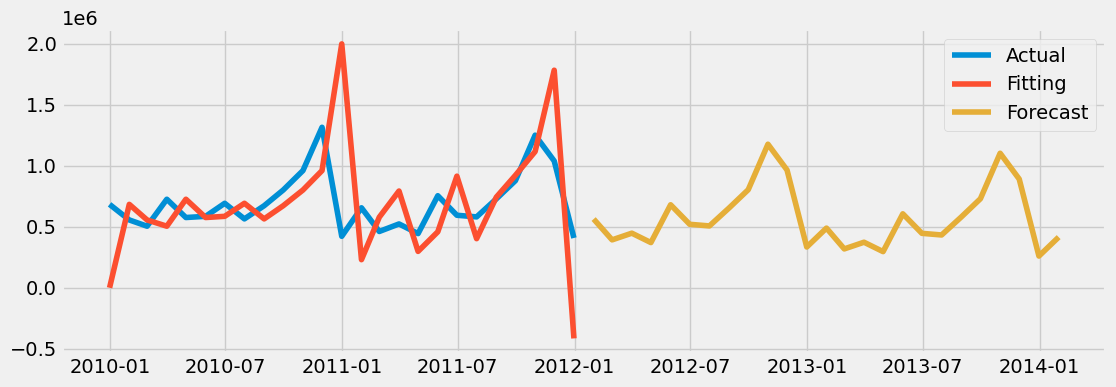

In [89]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(monthly_series['total_revenue'],label='Actual')
#plt.plot(monthly_series.index,fitting_mean,label='Predicted')
ax.plot(fitting_mean,label='Fitting')
ax.plot(forecast,label='Forecast')
plt.legend()
#fig.tight_layout()
plt.show()

NameError: name 'forecast2_mean' is not defined

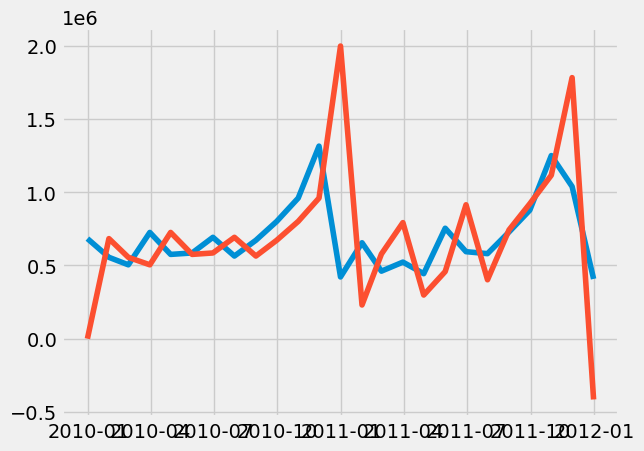

In [77]:
plt.plot(monthly_series['total_revenue'],label='Actual')
#plt.plot(monthly_series.index,fitting_mean,label='Predicted')
plt.plot(fitting_mean,label='Fitting')
plt.plot(forecast2_mean,label='Forecast')
plt.legend()
plt.show()

In [92]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
mape=mean_absolute_percentage_error(monthly_series['total_revenue'],forecast)
mape

0.2745337085344736

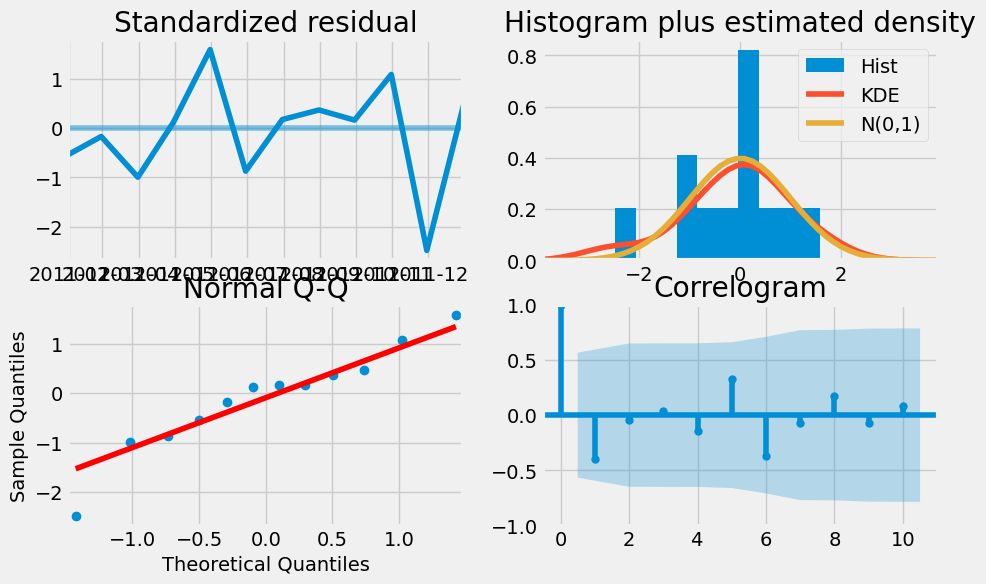

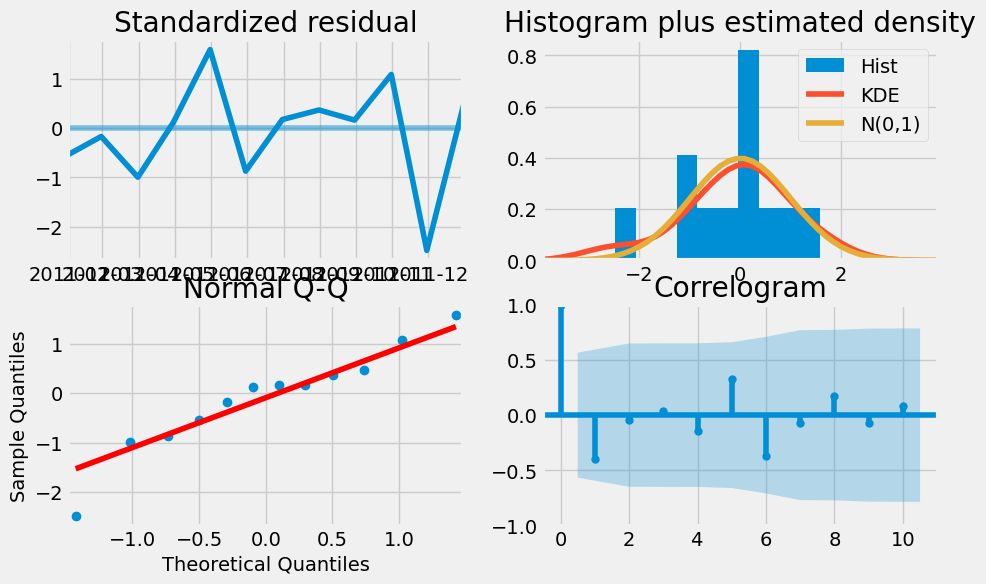

In [93]:
model.plot_diagnostics(figsize=(10,6))

## AUTO ARIMA

In [160]:
model_ARima= sm.tsa.statespace.SARIMAX(monthly_series,order= (1,1,1))
results_ARima= model_ARima.fit()

print(f"ARIMA Model: {results_ARima.aic}")

ARIMA Model: 672.0261771707899


In [161]:
fitting=results_ARima.get_prediction()

In [162]:
fitting_mean=fitting.predicted_mean

In [163]:
forecast=results.get_forecast(steps=12)
forecast_mean=forecast.predicted_mean

In [164]:
mape=mean_absolute_percentage_error(monthly_series['total_revenue'],fitting_mean)
mape

0.32021773933790393

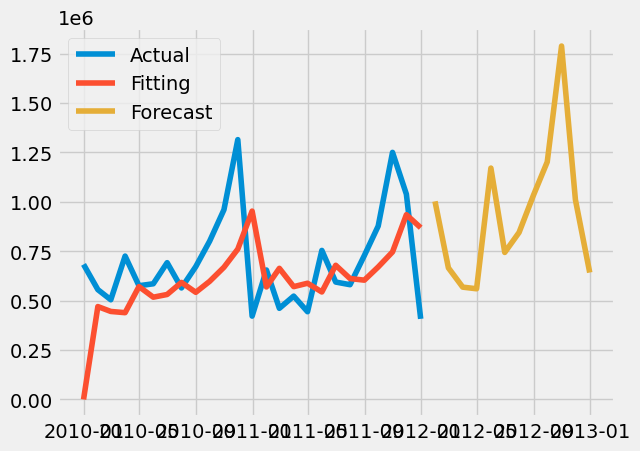

In [165]:
plt.plot(monthly_series['total_revenue'],label='Actual')
#plt.plot(monthly_series.index,fitting_mean,label='Predicted')
plt.plot(fitting_mean,label='Fitting')
plt.plot(forecast_mean,label='Forecast')
plt.legend()
plt.show()